# **Informatyka w medycynie**

# Dno oka

*Grupa dwuosobowa: Ivan Kaliadzich 153936, Mikołaj Diakowski 151843*

## Dodawanie bibliotek

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, restoration
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import imageio as imageio
from PIL import Image
import matplotlib.patches as mpatches
from skimage import io
from sklearn.tree import DecisionTreeClassifier

## Odczytanie obrazu

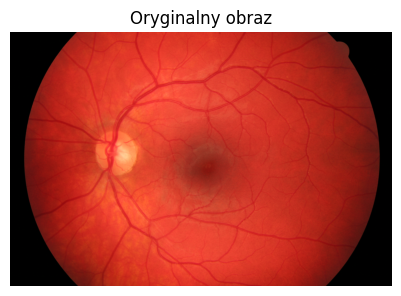

In [53]:
image_path = 'images/04_h.jpg' # obrazy 01-15; h - zdrowe oko, g - oko jaskrowe, dr - retinopatia cukrzycowa
image = cv2.imread(image_path)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Oryginalny obraz')

plt.tight_layout()
plt.axis('off')
plt.show()

## Wstępne przetwarzanie

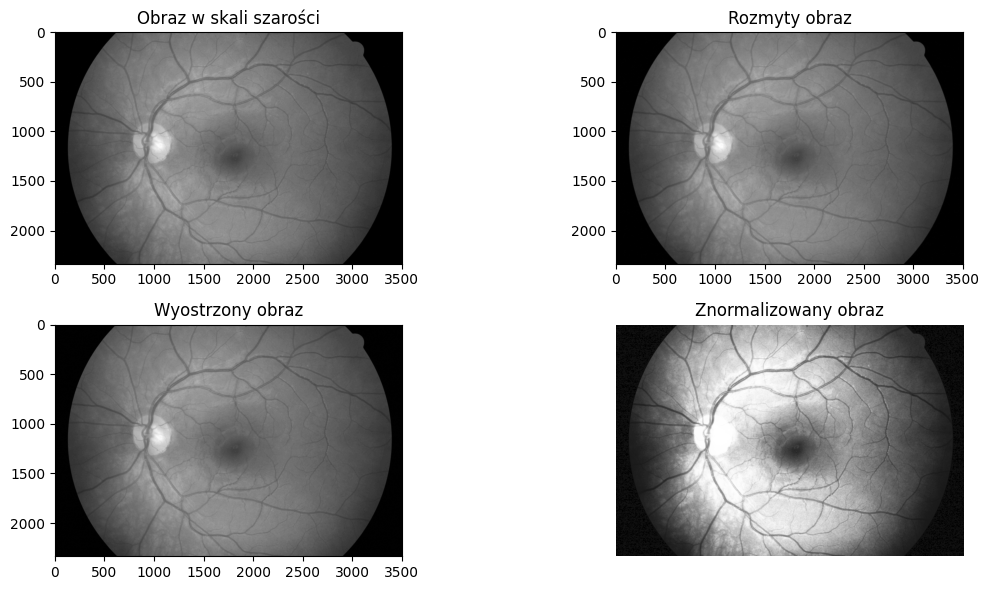

In [54]:
kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # w szkali szarości
blurry_image = cv2.blur(gray_image, (5,5)) # rozmyty obraz
sharpen_image = cv2.filter2D(blurry_image, -1, kernel) # wyostrzony obraz
normilize_image = cv2.equalizeHist(sharpen_image) # znormalizowany obraz

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Obraz w skali szarości')

plt.subplot(2, 2, 2)
plt.imshow(blurry_image, cmap='gray')
plt.title('Rozmyty obraz')

plt.subplot(2, 2, 3)
plt.imshow(sharpen_image, cmap='gray')
plt.title('Wyostrzony obraz')

plt.subplot(2, 2, 4)
plt.imshow(normilize_image, cmap='gray')
plt.title('Znormalizowany obraz')

plt.tight_layout()
plt.axis('off')
plt.show()

## Właściwe przetworzenie obrazu

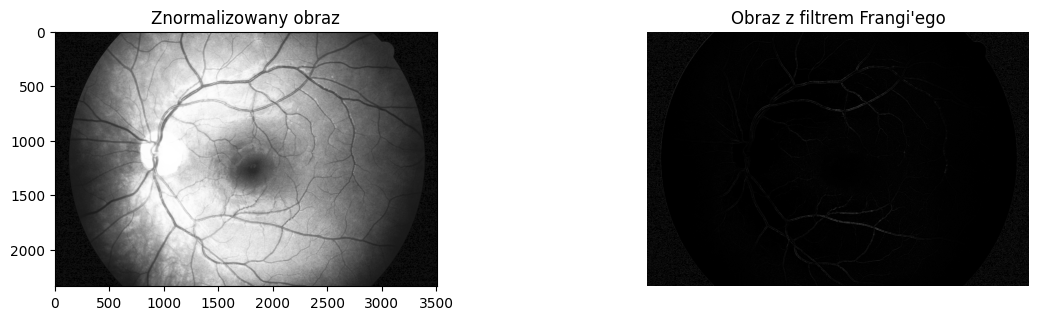

In [55]:
filtered_image = filters.frangi(normilize_image) # Zastosowanie filtru Frangi'ego

plt.figure(figsize = (12,6))

plt.subplot(2,2, 1)
plt.imshow(normilize_image, cmap='gray')
plt.title("Znormalizowany obraz")

plt.subplot(2,2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title("Obraz z filtrem Frangi'ego")


plt.tight_layout()
plt.axis('off')
plt.show()

## Końcowe przetwarzanie obraz

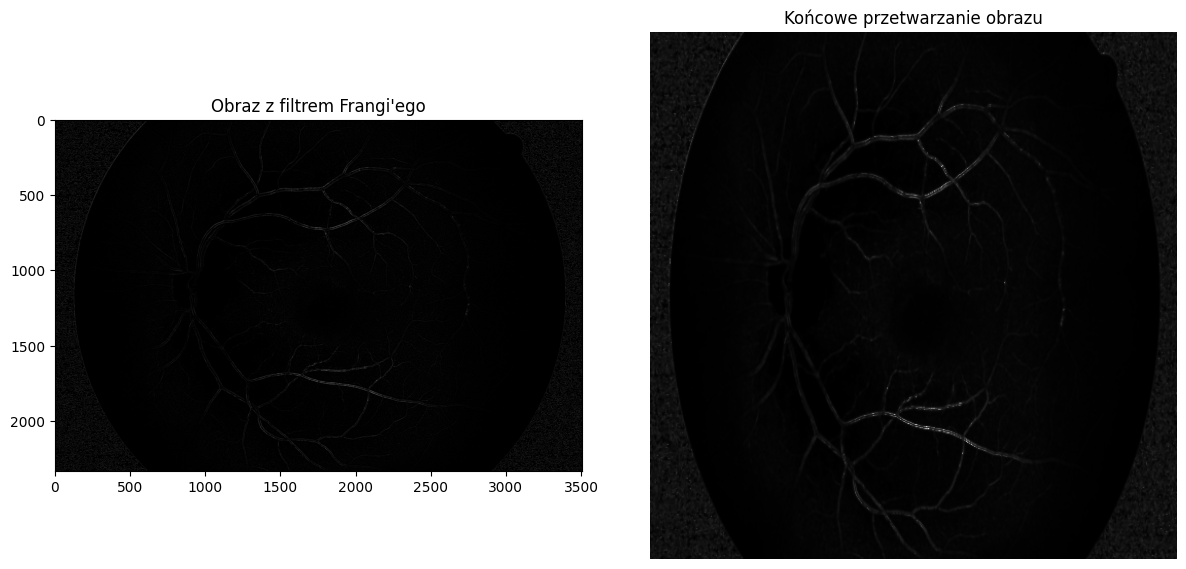

In [56]:
denoised_image = restoration.denoise_tv_chambolle(filtered_image, weight=0.1) # Odszumiony obraz
filled_image = restoration.inpaint_biharmonic(denoised_image, mask=(denoised_image == 0)) # Uzupełnieniony obraz
resized_image = cv2.resize(filled_image, (512, 512))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(filtered_image, cmap='gray')
plt.title("Obraz z filtrem Frangi'ego")

plt.subplot(1, 2, 2)
plt.imshow(resized_image, cmap='gray')
plt.title('Końcowe przetwarzanie obrazu')

plt.tight_layout()
plt.axis('off')
plt.show()

## Wizualizacja

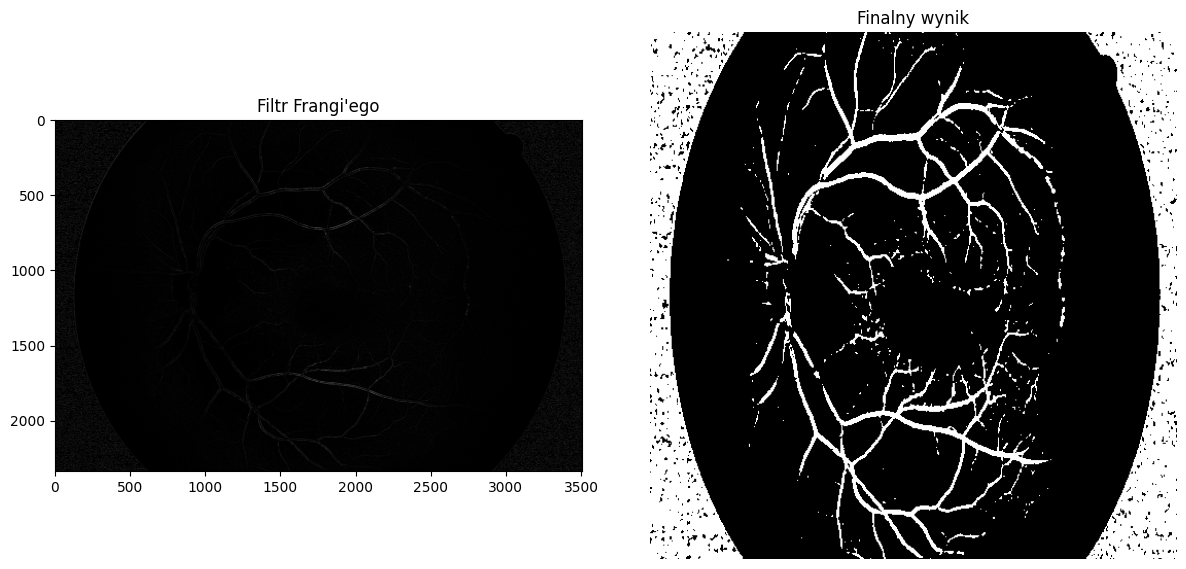

In [57]:
mask = resized_image > 0.01 # wygenerowanie binarnej maski

final_image = resized_image.copy()
final_image[mask] = 255


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtr Frangi\'ego')

plt.subplot(1, 2, 2)
plt.imshow(final_image, cmap='gray')
plt.title('Finalny wynik')


plt.tight_layout()
plt.axis('off')
plt.show()

## Skuteczność algorytmu

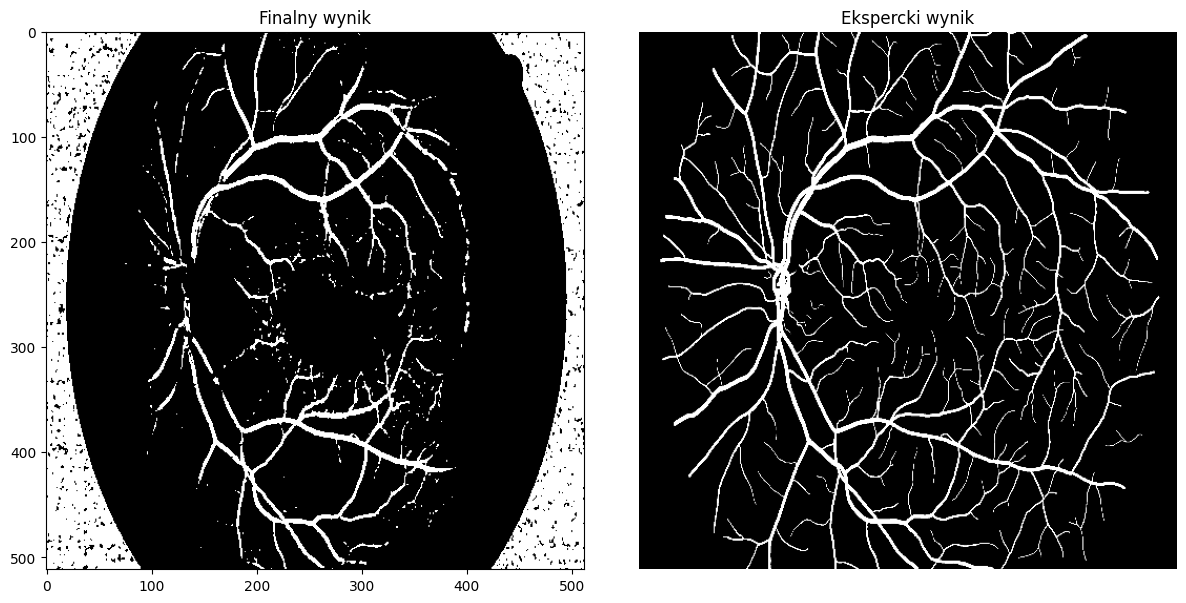

True

In [94]:
manual_image_path = 'manual1/04_h.tif'
manual_image = cv2.imread(manual_image_path)
manual_image = cv2.resize(manual_image, (512, 512))

gray_manual_image = cv2.cvtColor(manual_image, cv2.COLOR_BGR2GRAY) # Zmiana obrazu na skalę szarości

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(final_image, cmap='gray')
plt.title('Finalny wynik')

plt.subplot(1, 2, 2)
plt.imshow(gray_manual_image, cmap='gray')
plt.title('Ekspercki wynik')

plt.tight_layout()
plt.axis('off')
plt.show()

save_path = 'final_result_image.png'
cv2.imwrite(save_path, final_image)

save_path = 'expert_result_image.png'
cv2.imwrite(save_path, gray_manual_image)

In [59]:
correct_mask = gray_manual_image > 0 # Wygenerowanie binarnej eksperckiej maski
mask_height, mask_width = mask.shape



mask_path = 'mask/04_h_mask.tif' # używanie maski dla 04_h
tiff_image = Image.open(mask_path)
mask_pct = cv2.imread(mask_path)
mask_pct = cv2.resize(mask_pct, (512, 512))

gray_tiff_image = tiff_image.convert("L")
tiff_image_array = np.array(gray_tiff_image)
threshold = 127



# obliczanie macierzy pomyłek
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0

for i in range(mask_height):
    for j in range(mask_width):
        if tiff_image_array[i][j] > threshold:    
            if mask[i][j] == True and correct_mask[i][j] == True:
                true_positive += 1
            elif mask[i][j] == True and correct_mask[i][j] == False:
                false_positive += 1
            elif mask[i][j] == False and correct_mask[i][j] == True:
                false_negative += 1
            elif mask[i][j] == False and correct_mask[i][j] == False:
                true_negative += 1

print(true_positive, false_negative, false_positive, true_negative)

844 3048 12064 37504


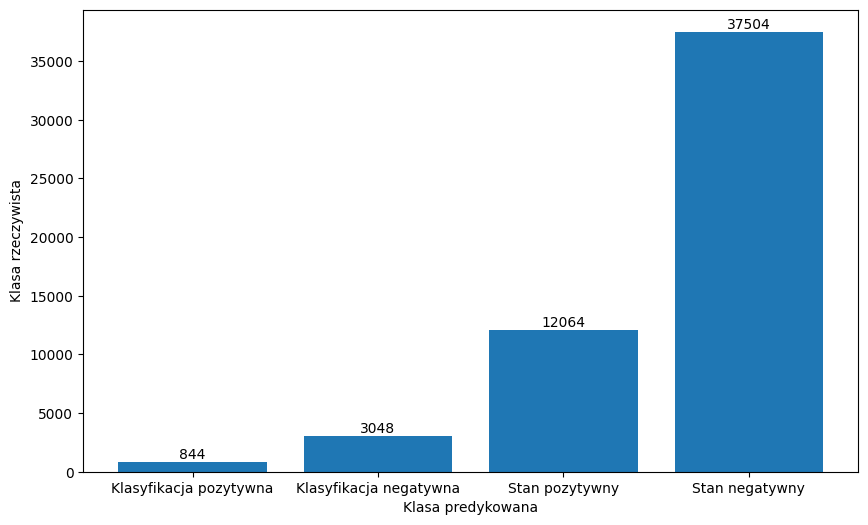

In [60]:
# Dane
values = [true_positive, false_negative, false_positive, true_negative]
labels = ['Klasyfikacja pozytywna', 'Klasyfikacja negatywna', 'Stan pozytywny', 'Stan negatywny']

# Utworzenie jednego wykresu słupkowego dla wszystkich kategorii
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, values)

# Dodanie etykiet do osi
ax.set_xlabel("Klasa predykowana")
ax.set_ylabel("Klasa rzeczywista")

# Ustawienie wartości na słupkach dla lepszej czytelności
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()


In [61]:
accuracy = (true_positive + true_negative)/(true_positive + false_positive + false_negative + true_negative)
print("Trafność:" ,accuracy)
sensitivity = (true_positive)/(true_positive + false_negative)
print("Czułość:",sensitivity)
specificity = (true_negative)/(false_positive + true_negative)
print("Swoistość:", specificity)
print("Średnia arytmetyczna czułości i swoistości:",(sensitivity + specificity)/2)

Trafność: 0.7173213617658062
Czułość: 0.21685508735868447
Swoistość: 0.7566171723692705
Średnia arytmetyczna czułości i swoistości: 0.4867361298639775


## Maсierz pomyłek

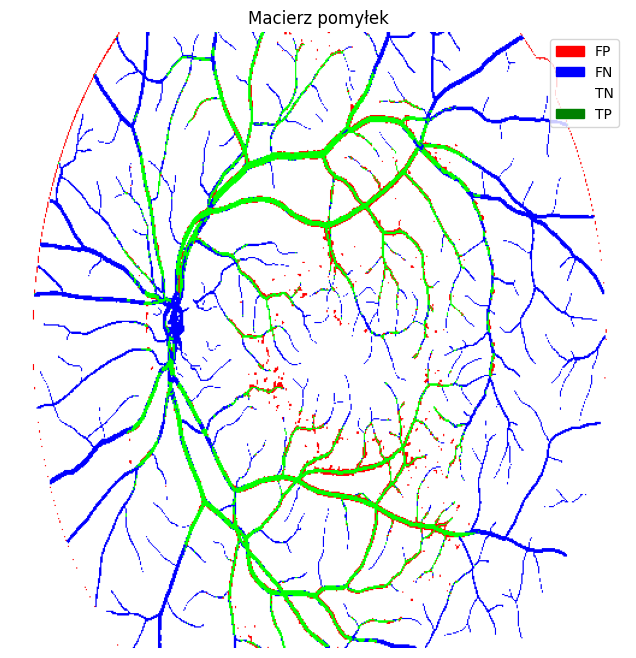

In [93]:

# Function to visualize and save the confusion matrix with a mask
def visualize_and_save_confusion_matrix_with_mask(expert_img, model_img, mask_img, filename):
    tp = (expert_img == 1) & (model_img == 1)
    tn = (expert_img == 0) & (model_img == 0)
    fp = (expert_img == 0) & (model_img == 1)
    fn = (expert_img == 1) & (model_img == 0)
    
    vis_image = np.zeros((expert_img.shape[0], expert_img.shape[1], 3), dtype=np.uint8)
    vis_image[tp] = [0, 255, 0]  # Green for TP
    vis_image[tn] = [255, 255, 255]  # White for TN
    vis_image[fp] = [255, 0, 0]  # Red for FP
    vis_image[fn] = [0, 0, 255]  # Blue for FN
    
    # Apply mask to set pixels to white where mask is black
    vis_image[mask_img == 0] = [255, 255, 255]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(vis_image)
    plt.title('Macierz pomyłek')
    plt.legend(handles=[
        mpatches.Patch(color='red', label='FP'),
        mpatches.Patch(color='blue', label='FN'),
        mpatches.Patch(color='white', label='TN'),
        mpatches.Patch(color='green', label='TP')
    ], loc='upper right')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  # Save the figure to a file
    plt.show()

# Load and process images
model_output_image = final_image  # Assuming final_image is loaded correctly
expert_image = gray_manual_image  # Assuming gray_manual_image is loaded correctly
path_to_mask = 'mask/04_h_mask.tif'
mask_image = cv2.imread(path_to_mask, cv2.IMREAD_GRAYSCALE)

# Resize images for consistency
resize_dim = (512, 512)
expert_image = cv2.resize(expert_image, resize_dim)
model_output_image = cv2.resize(model_output_image, resize_dim)
mask_image = cv2.resize(mask_image, resize_dim)

# Convert images to binary
threshold = 127
expert_image = (expert_image > threshold).astype(np.uint8)
model_output_image = (model_output_image > threshold).astype(np.uint8)
mask_image = (mask_image > threshold).astype(np.uint8)

# Visualize with the mask applied and save the output image
output_filename = 'saved_confusion_matrix.png'  # Specify the output file name here
visualize_and_save_confusion_matrix_with_mask(expert_image, model_output_image, mask_image, output_filename)

## Obraz wyjściowy drzewa decyzyjnego

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Załaduj obraz testowy
test_image_path = 'images/04_h.jpg'
image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512, 512))  # Dopasuj rozmiar do modelu

# Przygotuj dane do predykcji
features = image.flatten().reshape(-1, 1)  # Zakładając, że model używa pojedynczej cechy per piksel

# Wykonaj predykcję
predicted_labels = clf.predict(features)

# Przekształć wyniki predykcji z powrotem na format obrazu
predicted_image = predicted_labels.reshape(image.shape)

# Pokaż i zapisz wynik
plt.imshow(predicted_image, cmap='gray')  # Użyj odpowiedniej mapy kolorów dla różnych klas
plt.title('Obraz wyjściowy drzewa decyzyjnego')
plt.axis('off')
plt.show()


NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.